In [1]:
from __future__ import print_function

%matplotlib inline

import sys
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.contrib.framework.python.ops import variables

from collections import OrderedDict

import numpy as np
import scipy.misc
from input import *
from model import *
from train import *
import matplotlib.pyplot as plt
tf.reset_default_graph()

1.3.0


In [2]:
image_shape = (160,576)
iterator, filename = get_train_inputs(batch_size=100,
                                      repeat=True, 
                                      num_classes=2, 
                                      image_shape=image_shape)

**********
(160, 576, 3) (160, 576, 2)


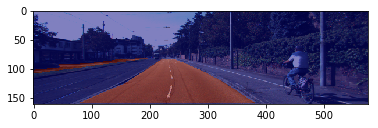

**********
(160, 576, 3) (160, 576, 2)


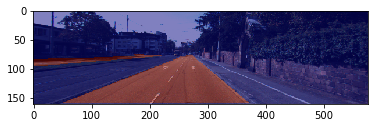

**********
(160, 576, 3) (160, 576, 2)


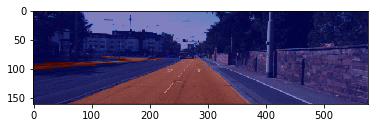

**********
(160, 576, 3) (160, 576, 2)


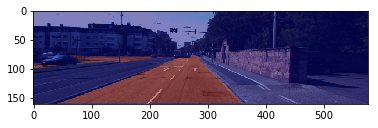

**********
(160, 576, 3) (160, 576, 2)


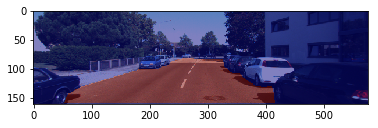

**********
(160, 576, 3) (160, 576, 2)


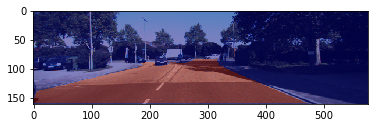

**********
(160, 576, 3) (160, 576, 2)


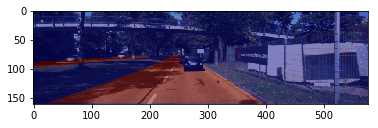

**********
(160, 576, 3) (160, 576, 2)


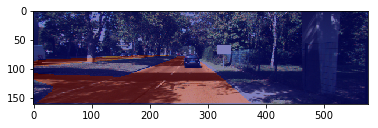

**********
(160, 576, 3) (160, 576, 2)


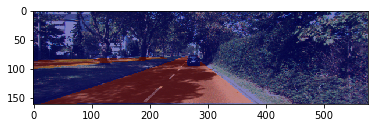

In [3]:
_show = True
if _show:
    with tf.Session() as sess:
        sess.run(iterator.initializer, feed_dict={filename: ['data/kitti_segmentation.tfrecord']})
        next_element = iterator.get_next()
        i = 1
        while i < 10:
            i += 1
            print("*"*10)
            image, label = sess.run(next_element)
            print(image.shape, label.shape)
            plt.imshow(np.uint8(image))
            plt.imshow(label[:,:,0], cmap='jet', alpha=0.5)
            plt.show()

In [4]:
# record_iterator = tf.python_io.tf_record_iterator(path='data/kitti_segmentation.tfrecord')
# string_record = next(record_iterator)
# example = tf.train.Example()
# example.ParseFromString(string_record)

## Model

In [5]:
encoder = SlimModelEncoder(name="vgg_16", num_classes=2, is_training=True)
image, label = iterator.get_next()
assign_op, feed_dict, end_points = encoder.build(image=image, image_shape=image_shape)

In [6]:
end_points.keys()

odict_keys(['vgg_16/conv1/conv1_1', 'vgg_16/conv1/conv1_2', 'vgg_16/pool1', 'vgg_16/conv2/conv2_1', 'vgg_16/conv2/conv2_2', 'vgg_16/pool2', 'vgg_16/conv3/conv3_1', 'vgg_16/conv3/conv3_2', 'vgg_16/conv3/conv3_3', 'vgg_16/pool3', 'vgg_16/conv4/conv4_1', 'vgg_16/conv4/conv4_2', 'vgg_16/conv4/conv4_3', 'vgg_16/pool4', 'vgg_16/conv5/conv5_1', 'vgg_16/conv5/conv5_2', 'vgg_16/conv5/conv5_3', 'vgg_16/pool5', 'vgg_16/fc6', 'vgg_16/fc7', 'vgg_16/fc8'])

In [7]:
print(end_points['vgg_16/conv3/conv3_3'], 
    end_points['vgg_16/conv4/conv4_3'], 
    end_points['vgg_16/conv5/conv5_3'],
    end_points['vgg_16/fc6'],
    end_points['vgg_16/fc7'],sep='\n')

Tensor("vgg_16/conv3/conv3_3/Relu:0", shape=(1, 40, 144, 256), dtype=float32)
Tensor("vgg_16/conv4/conv4_3/Relu:0", shape=(1, 20, 72, 512), dtype=float32)
Tensor("vgg_16/conv5/conv5_3/Relu:0", shape=(1, 10, 36, 512), dtype=float32)
Tensor("vgg_16/fc6/Relu:0", shape=(1, 5, 18, 4096), dtype=float32)
Tensor("vgg_16/fc7/Relu:0", shape=(1, 5, 18, 4096), dtype=float32)


In [8]:
decoder = FCNDecoder(end_points, nb_classes=2, scope='decoder')

In [9]:
tensors_to_connect = OrderedDict()
tensors_to_connect["vgg_16/fc7"] = (2,2)
tensors_to_connect['vgg_16/conv5/conv5_3'] = (2,2)
tensors_to_connect['vgg_16/conv4/conv4_3'] = (8,8)

In [10]:
net = decoder.build(tensors_to_connect)

In [12]:
assert tuple(tf.get_default_graph().get_tensor_by_name('logit:0').get_shape().as_list()[1:3]) == image_shape

## Train

In [13]:
trainer = Trainer(nb_classes=2, optimizer=tf.train.AdamOptimizer, learning_rate=3e-4)

In [14]:
trainer.build(predictions=net, labels=label, decoder_scope='decoder')

pred shape (92160, 2), label shape (92160, 2)


In [ ]:
trainer.train(iterator, assign_op=assign_op, feed_dict=feed_dict, filename=['data/kitti_segmentation.tfrecord'])

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'Iterator' object has no attribute 'name'
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/tf/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'Iterator' object has no attribute 'name'
INFO:tensorflow:global step 1: loss = 0.6943 (6.404 sec/step)
INFO:tensorflow:global step 2: loss = 0.6941 (2.931 sec/step)
INFO:tensorflow:Recording summary at step 2.
INFO:tensorflow:global step 3: loss = 0.6937 (2.828 sec/step)
INFO:tensorflow:global step 4: loss = 0.6935 (2.237 sec/step)
INFO:tensorflow:global step 5: loss = 0.6934 (2.319 sec/step)
INFO:tensorflow:global step 6: loss = 0.6931 (2.576 sec/step)
INFO:tensorflow:global step 7: loss = 0.6928 (2.756 sec/step)
INFO:tensorflow:global step 8: loss = 0.6925 (2.622 sec/step)
INFO:tensorflow:global step 9: loss 

## Predict

In [ ]:
TRAIN_DIR = "/tmp/tf"
with tf.Graph().as_default() as graph:
    image_shape = (160,576)
    iterator, filename = get_train_inputs(batch_size=100,
                                      repeat=False, 
                                      num_classes=2, 
                                      image_shape=image_shape)
    encoder = SlimModelEncoder(name="vgg_16", num_classes=2, is_training=False)
    image, label = iterator.get_next()
    assign_op, feed_dict, end_points = encoder.build(image=image, image_shape=image_shape)
    # tensors to connect and encoder
    decoder = FCNDecoder(end_points, nb_classes=2, scope='decoder')
    tensors_to_connect = OrderedDict()
    tensors_to_connect["vgg_16/fc7"] = (2,2)
    tensors_to_connect['vgg_16/conv5/conv5_3'] = (2,2)
    tensors_to_connect['vgg_16/conv4/conv4_3'] = (8,8)
    net = decoder.build(tensors_to_connect)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, os.path.join(TRAIN_DIR,"model.ckpt-10000"))
        input_tensor = graph.get_tensor_by_name('training_data/input:0')
        sess.run(iterator.initializer, feed_dict={input_tensor: ['data/kitti_segmentation.tfrecord']})
        # inference
        net = tf.squeeze(net)
        pred = tf.argmax(net, axis=2)
        label = sess.run(pred)
        img = sess.run(image)
        plt.imshow(np.uint8(img))
        plt.imshow(label, cmap='jet', alpha=0.5)
        print(label.mean())